In [1]:
import sys
sys.path.append("../../..")

##### import library

In [2]:
import pandas as pd
import numpy as np
import fcgr
from Bio import SeqIO
from tqdm import tqdm
import os
from scipy.stats import ttest_ind
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import utility

##### function to return p-value and effect size

In [3]:

def return_box_with_p_effect_size(ax, data, x_columns, y_columns, group1_name, group2_name, y_pos, hue_columns=None, fontsize=5):


    import pingouin as pg
    
    effect_size = dict()
    p_val = dict()
    
    # Extract x-tick labels and their positions from the Axes object
    xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
    # print(xtick_labels)
    xtick_positions = [tick.get_position()[0] for tick in ax.get_xticklabels()]

    try:

        if not hue_columns is None:
            

            for idx, (label, pos) in enumerate(zip(xtick_labels, xtick_positions)):
                # Filter data for the current x-tick category
                data_tmp = data[data[x_columns] == label]

                # Separate groups based on hue column
                group1 = data_tmp[data_tmp[hue_columns] == group1_name][y_columns]
                # print(group1)
                group2 = data_tmp[data_tmp[hue_columns] == group2_name][y_columns]


                p_value = ttest_ind(group1, group2, equal_var=False,  nan_policy='omit', alternative='greater').pvalue

    
                d_value = utility.median_based_distance(group1, group2)
      

                p_val[label] = p_value
                effect_size[label] = d_value

                # Annotate the plot with p-value and effect size
                ax.text(pos, y_pos, f"p: {p_value:.2e} \nd: {d_value:.2e}", ha="center", fontsize=fontsize, color="red")

                # print(f"x: {label}, P-value= {p_value:.2e} and effect size = {d_value:.2e} for ")
                print(f"P-value = {p_value:.2e} and effect size = {d_value:.2e} for {label},")

                # print("hello1")
                
            print("The median effect size is : " + str(pd.Series(effect_size.values()).median()))

            return ax
            
        if ((hue_columns is None) and (len(xtick_labels) == 2)):      
            # for idx, (label, pos) in enumerate(zip(xtick_labels, xtick_positions)): 
            group1 = data[data[x_columns] == group1_name][y_columns]
            group2 = data[data[x_columns] == group2_name][y_columns]

            
            # Compute p-value using Mann-Whitney U test
            p_value = ttest_ind(group1, group2, equal_var=False,  nan_policy='omit', alternative='greater').pvalue
            
            # Compute effect size using Cohen's d
            d_value = utility.median_based_distance(group1, group2)
            # print(d_value)
                
            # Annotate the plot with p-value and effect size
            ax.text(0.5, y_pos, f"p: {p_value:.2e} \nd: {d_value:.2e}", ha="center", fontsize=fontsize, color="red")
            
            print(f"P-value = {p_value:.2e} and effect size = {d_value:.2e}")
            


            # print(f"x: {label}, p-value: {p_value:.2e}, Cohen's d: {d_value:.2e}")
            return ax

    except:

        print("There is some error")




##### Set paramters

In [4]:
kmer_length = 10

# Paths to the reference FASTA file and mutation CSV file
fasta_file_path = "../../../data/GCF_000005845.2_ASM584v2_genomic.fna"

##### Read VCF files

In [5]:

# Input and output paths
vcf_dir = "../../../data/vcf/"

# Define the headers you want
custom_headers = [
    "CHROM", "POS", "ID", "REF", "ALT", "QUAL", "INFO", "FORMAT", "SAMPLE_GENOTYPE",
    "CHROM_ANNOT", "START", "END", "GENE", "ANNOT_ID", "STRAND", "SOURCE"
]

# Initialize an empty list to hold data
all_data = []

# Get all VCF files in the directory
vcf_files = glob.glob(os.path.join(vcf_dir, "*_annotated.vcf"))

# Process each VCF file
for file_path in vcf_files:
    file_name = os.path.basename(file_path)  # Extract file name
    print(f"Processing file: {file_name}")
    
    with open(file_path, 'r') as f:
        for line in f:
            if not line.startswith("#"):  # Skip header lines
                # Split each row by tab
                columns = line.strip().split("\t")
                
                # Ensure sufficient columns exist for parsing
                if len(columns) >= 16:
                    # Extract standard VCF and annotation data
                    chrom = columns[0]
                    pos = columns[1]
                    vcf_id = columns[2]
                    ref = columns[3]
                    alt = columns[4]
                    qual = columns[5]
                    info = columns[7]
                    format_col = columns[8]
                    sample_data = columns[9]
                    chrom_annot = columns[10]
                    start = columns[11]
                    end = columns[12]
                    gene = columns[13]
                    annot_id = columns[14]
                    strand = columns[15]
                    
                    # Add the source column (file name)
                    row = [
                        chrom, pos, vcf_id, ref, alt, qual, info, format_col, sample_data,
                        chrom_annot, start, end, gene, annot_id, strand, file_name
                    ]
                    all_data.append(row)

# Convert all data to a single DataFrame
df_combined = pd.DataFrame(all_data, columns=custom_headers)
# df_combined


Processing file: F_annotated.vcf
Processing file: P1R3_annotated.vcf
Processing file: P3R3_annotated.vcf
Processing file: P2R3_annotated.vcf
Processing file: P5R3_annotated.vcf
Processing file: D5_annotated.vcf
Processing file: P2R1_annotated.vcf
Processing file: P3R1_annotated.vcf
Processing file: D3_annotated.vcf
Processing file: D4_annotated.vcf
Processing file: P5R1_annotated.vcf
Processing file: P1R1_annotated.vcf
Processing file: P4R3_annotated.vcf
Processing file: P4R1_annotated.vcf
Processing file: D1_annotated.vcf
Processing file: D2_annotated.vcf
Processing file: WT7_annotated.vcf


##### Apply all the filter

In [6]:
# Filter the data based on Qual >= 20
filtered_df = df_combined[df_combined['QUAL'].astype(float) >= 20]
filtered_df['DP'] = filtered_df['INFO'].str.extract(r'DP=(\d+)').astype(int)
filtered_df = filtered_df[filtered_df['DP'] >= 10]
# Filter rows where both REF and ALT are exactly 1 character long
filtered_df = filtered_df[(filtered_df['REF'].str.len() == 1) & (filtered_df['ALT'].str.len() == 1)]
# Reset the index for the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)
filtered_df

/tmp/ipykernel_2385211/4260451231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['DP'] = filtered_df['INFO'].str.extract(r'DP=(\d+)').astype(int)


,CHROM,POS,ID,REF,ALT,QUAL,INFO,FORMAT,SAMPLE_GENOTYPE,CHROM_ANNOT,START,END,GENE,ANNOT_ID,STRAND,SOURCE,DP
0,NC_000913.3,346287,.,C,T,7279.15,AB=0;ABP=0;AC=24;AF=1;AN=24;AO=225;CIGAR=1X;DP...,GT:DP:RO:QR:AO:QA,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,NC_000913.3,345665,346337,yahN,.,-,F_annotated.vcf,225
1,NC_000913.3,803662,.,C,A,7050.3,AB=0;ABP=0;AC=24;AF=1;AN=24;AO=218;CIGAR=1X;DP...,GT:DP:RO:QR:AO:QA,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,NC_000913.3,803502,805764,ybhJ,.,+,F_annotated.vcf,218
2,NC_000913.3,1905761,.,G,A,6079.12,AB=0;ABP=0;AC=24;AF=1;AN=24;AO=201;CIGAR=1X;DP...,GT:DP:RO:QR:AO:QA,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,NC_000913.3,1905687,1906254,mntP,.,+,F_annotated.vcf,203
3,NC_000913.3,2411051,.,G,C,6693.91,AB=0;ABP=0;AC=24;AF=1;AN=24;AO=208;CIGAR=1X;DP...,GT:DP:RO:QR:AO:QA,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,NC_000913.3,2409519,2411352,yfbS,.,-,F_annotated.vcf,208
4,NC_000913.3,3391407,.,A,C,103.465,AB=0.257282;ABP=108.422;AC=6;AF=0.25;AN=24;AO=...,GT:DP:RO:QR:AO:QA,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/1/1/1/1/1/...,NC_000913.3,3390582,3392028,tldD,.,-,F_annotated.vcf,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NC_000913.3,3474393,.,G,T,7591.16,AB=0;ABP=0;AC=24;AF=1;AN=24;AO=242;CIGAR=1X;DP...,GT:DP:RO:QR:AO:QA,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,NC_000913.3,3474177,3474552,rpsL,.,-,D2_annotated.vcf,244
96,NC_000913.3,346287,.,C,T,5546.93,AB=0;ABP=0;AC=24;AF=1;AN=24;AO=172;CIGAR=1X;DP...,GT:DP:RO:QR:AO:QA,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,NC_000913.3,345665,346337,yahN,.,-,WT7_annotated.vcf,172
97,NC_000913.3,803662,.,C,A,5926.02,AB=0;ABP=0;AC=24;AF=1;AN=24;AO=184;CIGAR=1X;DP...,GT:DP:RO:QR:AO:QA,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,NC_000913.3,803502,805764,ybhJ,.,+,WT7_annotated.vcf,184
98,NC_000913.3,1905761,.,G,A,5029.32,AB=0;ABP=0;AC=24;AF=1;AN=24;AO=157;CIGAR=1X;DP...,GT:DP:RO:QR:AO:QA,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,NC_000913.3,1905687,1906254,mntP,.,+,WT7_annotated.vcf,159


##### Calculate kGain

In [7]:

# Load the single DNA sequence from the FASTA file
fasta_seq = next(SeqIO.parse(fasta_file_path, "fasta")).seq  # Assuming one sequence in the file
seq_length = len(fasta_seq)
fasta_seq_str = str(fasta_seq)  # Convert to string for easy manipulation

# Step 1: Load the mutations from your CSV file
df_mutations = filtered_df.copy()  # Assuming 'df' is already loaded as a DataFrame containing your mutations.

# Function to extract flanks for each mutation
def extract_flanks(sequence, pos, alt_base, kmer_length):
    seq_length = len(sequence)
    # Define the flanking region around the mutation
    start = max(0, pos - kmer_length)
    end = min(seq_length, pos + kmer_length + 1)
    
    # Extract the reference flank
    ref_flank = sequence[start:end]
    
    # Create the alternate flank by introducing the mutation
    alt_flank = ref_flank[:(pos - start)] + alt_base + ref_flank[(pos - start + 1):]
    
    return ref_flank, alt_flank

# Helper functions for k-gain calculation
def calculateKgain(kmer_dict, ref_allele, alt_allele):
    try:
        ref_freq = float(kmer_dict.get(ref_allele, 1e-10))  # Laplace smoothing
        alt_freq = float(kmer_dict.get(alt_allele, 1e-10))  
        score = np.log(alt_freq / ref_freq)
    except KeyError:
        score = 0
    return score

def calculateAccumulated(kgain_scores):
    return sum(kgain_scores)

def getMaxKgain(kgain_scores):
    return max(kgain_scores)

# Step 2: Compute Chaos Frequency Dictionary for the reference sequence using kmer_length
fcgr_sequence = fcgr.chaos_frequency_dictionary(
    fasta_string=fasta_seq_str,
    kmer_length=kmer_length,
    pseudo_count=True
)

# Preallocate a list to collect results
results = []

# Step 3: Perform k-mer analysis on the mutations from your file
for idx, row in tqdm(df_mutations.iterrows(), desc="Processing Mutations", total=len(df_mutations)):
    pos = int(row['POS']) - 1  # Adjust for 0-based indexing
    ref_base = row['REF']  # Reference base
    alt_base = row['ALT']  # Alternate base
    source = row['SOURCE']  # Extract the SOURCE column
    
    # Extract flanking regions for the mutation
    ref_flank, alt_flank = extract_flanks(fasta_seq_str, pos, alt_base, kmer_length)
    
    # Find the center of the flanking sequence
    center_pos = int(len(ref_flank) / 2)
    
    # Precompute the sliding windows for k-mers
    ref_kmers = [ref_flank[center_pos - kmer_length + j + 1:center_pos + j + 1] for j in range(kmer_length)]
    alt_kmers = [alt_flank[center_pos - kmer_length + j + 1:center_pos + j + 1] for j in range(kmer_length)]

    # print(ref_kmers, alt_kmers)

    
    # Compute k-gain scores for each sliding window
    kgain_scores = [
        calculateKgain(fcgr_sequence, ref_kmer, alt_kmer)
        for ref_kmer, alt_kmer in zip(ref_kmers, alt_kmers)
    ]

    # print(kgain_scores)


    
    # Calculate accumulated gain and max gain
    accumulated_gain = calculateAccumulated(kgain_scores)
    max_gain = getMaxKgain(kgain_scores)
    
    # Collect results for this mutation, including the SOURCE column
    for j in range(kmer_length):
        result = row.to_dict()  # Keep all original columns from your mutation file
        result.update({
            'REF_FLANK': ref_flank,
            'ALT_FLANK': alt_flank,
            'altered sliding window': alt_kmers[j],
            'reference sliding window': ref_kmers[j],
            'kgain': kgain_scores[j],
            'accumulated_gain': accumulated_gain,
            'max_gain': max_gain,
            'SOURCE': source  # Include the SOURCE column here
        })
        results.append(result)

# Convert the results list to a DataFrame
df_complete = pd.DataFrame(results)

# Drop duplicates based on the specified subset of columns
df_complete.drop_duplicates(subset=['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'INFO', 'FORMAT',
                                    'SAMPLE_GENOTYPE', 'CHROM_ANNOT', 'START', 'END', 'GENE',
                                    'ANNOT_ID', 'STRAND', 'SOURCE', 'DP', 'REF_FLANK', 'ALT_FLANK'],
                            inplace=True)

# Reset the index and drop the old index
df_complete.reset_index(inplace=True, drop=True)

df_complete['SOURCE'] = df_complete['SOURCE'].str.split('_').str[0]
df_complete['AF'] = df_complete['INFO'].str.extract(r'AF=([\d\.]+)')


Processing Mutations: 100%|██████████| 100/100 [00:00<00:00, 2870.53it/s]


##### Divide the data across source category

In [8]:
# Define conditions for the new column
df_complete["source category"] = np.where(
    df_complete["SOURCE"].str.contains("D"), "D",
    np.where(df_complete["SOURCE"].str.contains("R1"), "R1",
    np.where(df_complete["SOURCE"].str.contains("R3"), "R3",
    np.where(df_complete["SOURCE"].str.contains("WT7"), "WT7",
    np.where(df_complete["SOURCE"].str.contains("F"), "F", "")))))  # Added correct number of closing parentheses


In [9]:
df_complete["source category"].value_counts()

source category
D      36
R1     29
R3     26
F       5
WT7     4
Name: count, dtype: int64

In [10]:
# Define the groups to process
groups = ['D', 'R1', 'R3', 'WT7', 'F']

complete_data = pd.DataFrame(columns=['POS', 'GENE', 'REF', 'ALT', 'count'])

# Loop through each group and compute counts
for group in groups:

    # print(group)
    # Filter the DataFrame for the specific group (based on `SOURCE` containing group keyword)
    df_filtered = df_complete[df_complete["source category"]==group][['POS', 'GENE', 'REF', 'ALT']].value_counts().reset_index()
    df_filtered["source category"] = group
    # df_filtered = pd.merge(df_complete[['POS', 'REF', 'ALT', 'GENE', "accumulated_gain"]], complete_data)
    # complete_data = pd.merge(df_filtered, complete_data, how = "left")

    # print(df_filtered.shape)
    complete_data = pd.concat([complete_data, df_filtered])
    

complete_data['mutation_type'] = complete_data['count'].apply(
    lambda x: 'Carry forward' if x >= 4 else 'Non carry forward'
)
complete_data.reset_index(inplace=True, drop=True)
complete_data = pd.merge(df_complete[['POS', 'REF', 'ALT', 'GENE',  'source category',"accumulated_gain", "AF"]], complete_data)
# Ensure numeric data types for the relevant columns
complete_data['AF'] = pd.to_numeric(complete_data['AF'], errors='coerce')
complete_data['AF_category'] = complete_data['AF'].apply(lambda x: 'AF < 1' if x < 1 else 'AF = 1')
# complete_data = pd.merge(df_complete, complete_data)
complete_data

,POS,REF,ALT,GENE,source category,accumulated_gain,AF,count,mutation_type,AF_category
0,346287,C,T,yahN,F,-3.401197,1.000,1,Non carry forward,AF = 1
1,803662,C,A,ybhJ,F,8.135142,1.000,1,Non carry forward,AF = 1
2,1905761,G,A,mntP,F,2.281896,1.000,1,Non carry forward,AF = 1
3,2411051,G,C,yfbS,F,-6.132888,1.000,1,Non carry forward,AF = 1
4,3391407,A,C,tldD,F,-2.793208,0.250,1,Non carry forward,AF < 1
...,...,...,...,...,...,...,...,...,...,...
95,4104222,T,G,cpxA,D,-8.300336,0.875,1,Non carry forward,AF < 1
96,346287,C,T,yahN,WT7,-3.401197,1.000,1,Non carry forward,AF = 1
97,803662,C,A,ybhJ,WT7,8.135142,1.000,1,Non carry forward,AF = 1
98,1905761,G,A,mntP,WT7,2.281896,1.000,1,Non carry forward,AF = 1


<!-- #####  -->

##### Fig S4b. Source category wise count with AF as hue

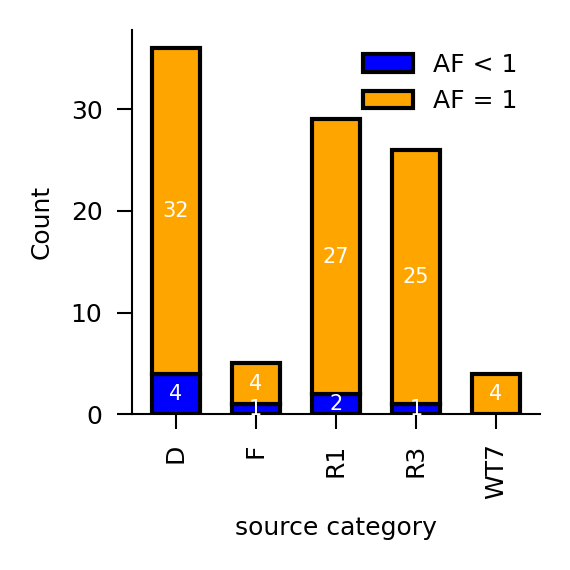

In [11]:
# Group by source group and allele count category
grouped_counts = (
    complete_data
    .groupby(['source category', 'AF_category'])['AF']
    .count()
    .unstack(fill_value=0)
)
#  Define colors for "Equal to 1" and "Not Equal to 1"
colors = ["blue", "orange"]

# Plot a stacked bar chart
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300)  # Adjusted figure size for better aspect ratio

# Stacked bar plot for "Equal to 1" and "Not Equal to 1" categories
bar_containers = grouped_counts.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor='black',
    width=0.6  # Adjusted bar width for better proportion
)


# Customize legend
legend_labels = [
    "AF = 1", 
    "AF < 1"
]

# Annotate counts on all stacks
for bar_group, col_name in zip(bar_containers.containers, grouped_counts.columns):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # Center of the bar
                bar.get_y() + height / 2,          # Center of the stack
                f"{int(height)}",                 # Convert count to integer
                ha="center", va="center", fontsize=5, color="white"
            )

ax.legend(ncol =1, fontsize = 6, frameon=False)
# ax.set_title("a", fontsize = 6)
ax = utility.custom_figure_axis(ax=ax, fontsize = 6)
ax.set_ylabel("Count")
# Adjust layout
plt.tight_layout()

##### Fig S4c. Sorce category wise count carry forward vs non carry forward

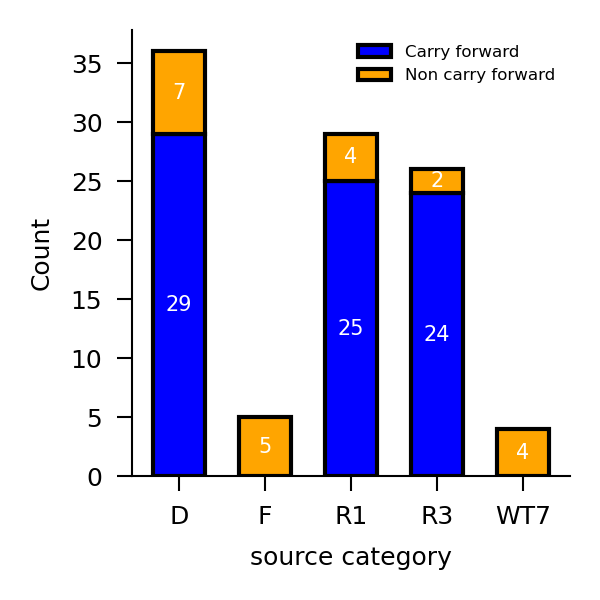

In [12]:
# # Group by source group and allele count category
# grouped_counts = (
#     complete_data
#     .groupby(['source category', 'mutation_type'])['mutation_type']
#     .count()
#     .unstack(fill_value=0)
# )


grouped_counts = complete_data.groupby(['source category', "mutation_type"])["accumulated_gain"].count().unstack(fill_value=0)

#  Define colors for "Equal to 1" and "Not Equal to 1"
colors = ["blue", "orange"]

# Plot a stacked bar chart
fig, ax = plt.subplots(figsize=(2.1, 2.1), dpi=300)  # Adjusted figure size for better aspect ratio

# Stacked bar plot for "Equal to 1" and "Not Equal to 1" categories
bar_containers = grouped_counts.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor='black',
    width=0.6  # Adjusted bar width for better proportion
)

# Add labels and title
# ax.set_title("Stacked Bar Plot: Allele Count (Equal to 1 vs Not Equal to 1)", fontsize=12)
# ax.set_xlabel("Source Group", fontsize=10)
# ax.set_ylabel("Allele Count", fontsize=10)

# Customize legend
legend_labels = [
    "Equal to 1", 
    "Not Equal to 1"
]
# ax.legend(labels=legend_labels, title="Allele Count Category", fontsize=8, title_fontsize=9, loc="upper right")

# Annotate counts on all stacks
for bar_group, col_name in zip(bar_containers.containers, grouped_counts.columns):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # Center of the bar
                bar.get_y() + height / 2,          # Center of the stack
                f"{int(height)}",                 # Convert count to integer
                ha="center", va="center", fontsize=5, color="white"
            )

ax.legend(ncol =1, fontsize = 4, frameon=False)

ax = utility.custom_figure_axis(ax=ax, fontsize = 6, rotation = 0)
ax.set_ylabel("Count")
# Adjust layout
plt.tight_layout()
plt.savefig("Source categorywise count cf ncf.pdf", dpi = 300)